# Xiaoxiao ideas - [Issue #4](https://github.com/lucasbaldezzari/babesbayes-nma/issues/4)

[Xiaoxiao Doc](https://docs.google.com/document/d/1ys_EPqGpgCpRjzoqy-FVsiz_0CSuJ6rjZm9zMbDGj94/edit)

#### Colaborators
- Xiaoxiao
- Lucas
- Erik

---

In [1]:
##importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests
from numpy import pi
import seaborn as sns

from utils import getAngles, get_cartesian_to_deg, limitingAngles

In [2]:
data = pd.read_csv("dataset\\data01_direction4priors.csv") ##open file

### Dropping rows with NaN values 

In [3]:
### Dropping rows with NaN values 
data = data.dropna()

## Deleting some subjects

**DO NOT** use subject 2, it seems it has NaN values for almost all important rows. In the [Knowing_the_Data.ipynb](https://github.com/lucasbaldezzari/babesbayes-nma/blob/main/coding/Knowing_the_Data.ipynb) colab you can see in the *missing_values* variable that there are several NaN values for the columns 'response_arrow_start_angle', 'reaction_time' and 'raw_response_time'. In my opinion, we should not use the subjects 1, 2, 3 and 4.

So, I will drop all the rows for those subjects.

In [4]:
##delete the rows for subject_id 2
data = data[~data['subject_id'].isin([2])]
data["subject_id"].unique()

array([ 1,  3,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

## Processing the data and adding some columns

### 1 Adding *reaction_time_range*

In [5]:
data_processed = data.copy()

In [6]:
ranges = np.arange(0,data_processed.loc[:,"reaction_time"].max(),0.1).round(2)
# print(ranges)
data_processed.loc[:,"reaction_time_range"] = pd.cut(data_processed.loc[:,"reaction_time"], bins=ranges, labels=False)+1

if data_processed.loc[:,'reaction_time_range'].isnull().sum() > 0: ##deleting rows with NaN values
    data_processed = data_processed.dropna(subset=['reaction_time_range'])

indexes = data_processed.loc[:,'reaction_time_range'].value_counts().sort_index().index.astype(int) #get the sorted index
x_labels = np.round(ranges[indexes],1) #filtering the range values using the sorted indexes

## add a reaction_time_range_label column to the data_processed dataframe using the x_labels.
## Loop through the reaction_time_range column and get the corresponding x_labels value
data_processed.loc[:,"reaction_time_range_label"] = data_processed.loc[:,"reaction_time_range"].apply(lambda x: ranges[int(x)] if x < len(ranges) else 0)

In [7]:
print("The ranges in seconds are")
print(ranges)

The ranges in seconds are
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7]


### 2. Getting estimated angles

We will use two function to get the estimated angles, one using our approach and the Liquitaine approach.

In [8]:
x = data_processed['estimate_x'].values
y = data_processed['estimate_y'].values
##using estimate_x and estimate_y to calculate the angle using our function getAngles
data_processed.loc[:,'estimate_angles'] = np.round(getAngles(x, y, limits=360), 3)
##getting the difference between the motion direction and the estimate angles
data_processed.loc[:,'diff_angles'] = data_processed['motion_direction'] - data_processed['estimate_angles']
##limiting the angles to -180 and 180
data_processed.loc[:,'diff_angles_180'] = limitingAngles(data_processed.loc[:,'diff_angles'].values, bottom=-180, top=180)

##repeat the same but using get_cartesian_to_deg function
data_processed.loc[:,'estimate_angles_liqui'] = np.round(get_cartesian_to_deg(x, y, signed=True), 3)
data_processed.loc[:,'diff_angles_liqui'] = data_processed['motion_direction'] - data_processed['estimate_angles_liqui']
##limiting the angles to -180 and 180
data_processed.loc[:,'diff_angles_liqui_180'] = limitingAngles(data_processed.loc[:,'diff_angles_liqui'].values, bottom=-180, top=180)

Comparing the estimated angles we have just calculated.

In [9]:
data_processed.loc[:,['estimate_angles',"estimate_angles_liqui"]].describe()

,estimate_angles,estimate_angles_liqui
count,51343.000000,51343.000000
mean,209.848227,209.848227
std,68.497320,68.497320
min,0.033000,0.033000
25%,188.870000,188.870000
50%,221.531000,221.531000
75%,245.466000,245.466000
max,359.960000,359.960000


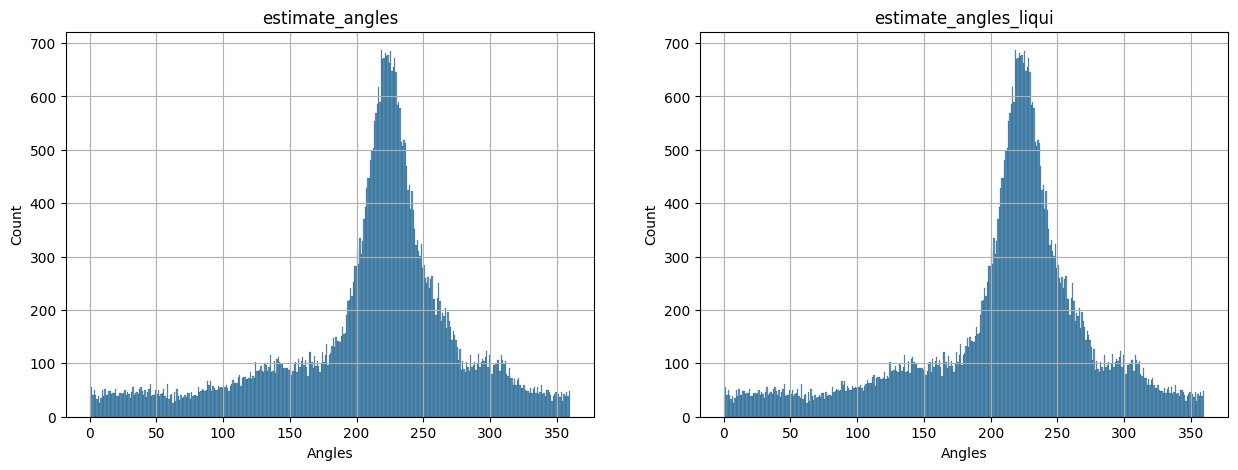

In [10]:
##histograms of estimate_angles and	estimate_angles_liqui
n_bins = 360
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.histplot(data=data_processed, x='estimate_angles', bins=n_bins, ax=ax[0])
sns.histplot(data=data_processed, x='estimate_angles_liqui', bins=n_bins, ax=ax[1])
ax[0].set_title("estimate_angles")
ax[1].set_title("estimate_angles_liqui")
ax[0].set_xlabel("Angles")
ax[1].set_xlabel("Angles")
ax[0].grid()
ax[1].grid()
plt.show()

It seems we have the same estimated angles from both functions.

Let's compare the difference angles between the motion direction and the estimated angles. 

In [11]:
data_processed.loc[:,['diff_angles',"diff_angles_180","diff_angles_liqui","diff_angles_liqui_180"]].describe()

,diff_angles,diff_angles_180,diff_angles_liqui,diff_angles_liqui_180
count,51343.000000,51343.000000,51343.000000,51343.000000
mean,7.160031,0.660216,7.160031,0.660216
std,67.768482,50.235159,67.768482,50.235159
min,-354.804000,-179.964000,-354.804000,-179.964000
25%,-17.719000,-19.444000,-17.719000,-19.444000
50%,1.297000,0.126000,1.297000,0.126000
75%,21.824500,19.552000,21.824500,19.552000
max,354.843000,179.935000,354.843000,179.935000


In [12]:
##getting the interquartile range for the diff_angles, diff_angles_180, diff_angles_liqui, diff_angles_liqui_180
q1 = data_processed.loc[:,['diff_angles',"diff_angles_180","diff_angles_liqui","diff_angles_liqui_180"]].quantile(0.25)
q3 = data_processed.loc[:,['diff_angles',"diff_angles_180","diff_angles_liqui","diff_angles_liqui_180"]].quantile(0.75)
iqr = q3 - q1
print("Interquartile range for diff_angles, diff_angles_180, diff_angles_liqui, diff_angles_liqui_180")
print(iqr)


Interquartile range for diff_angles, diff_angles_180, diff_angles_liqui, diff_angles_liqui_180
diff_angles              39.5435
diff_angles_180          38.9960
diff_angles_liqui        39.5435
diff_angles_liqui_180    38.9960
dtype: float64


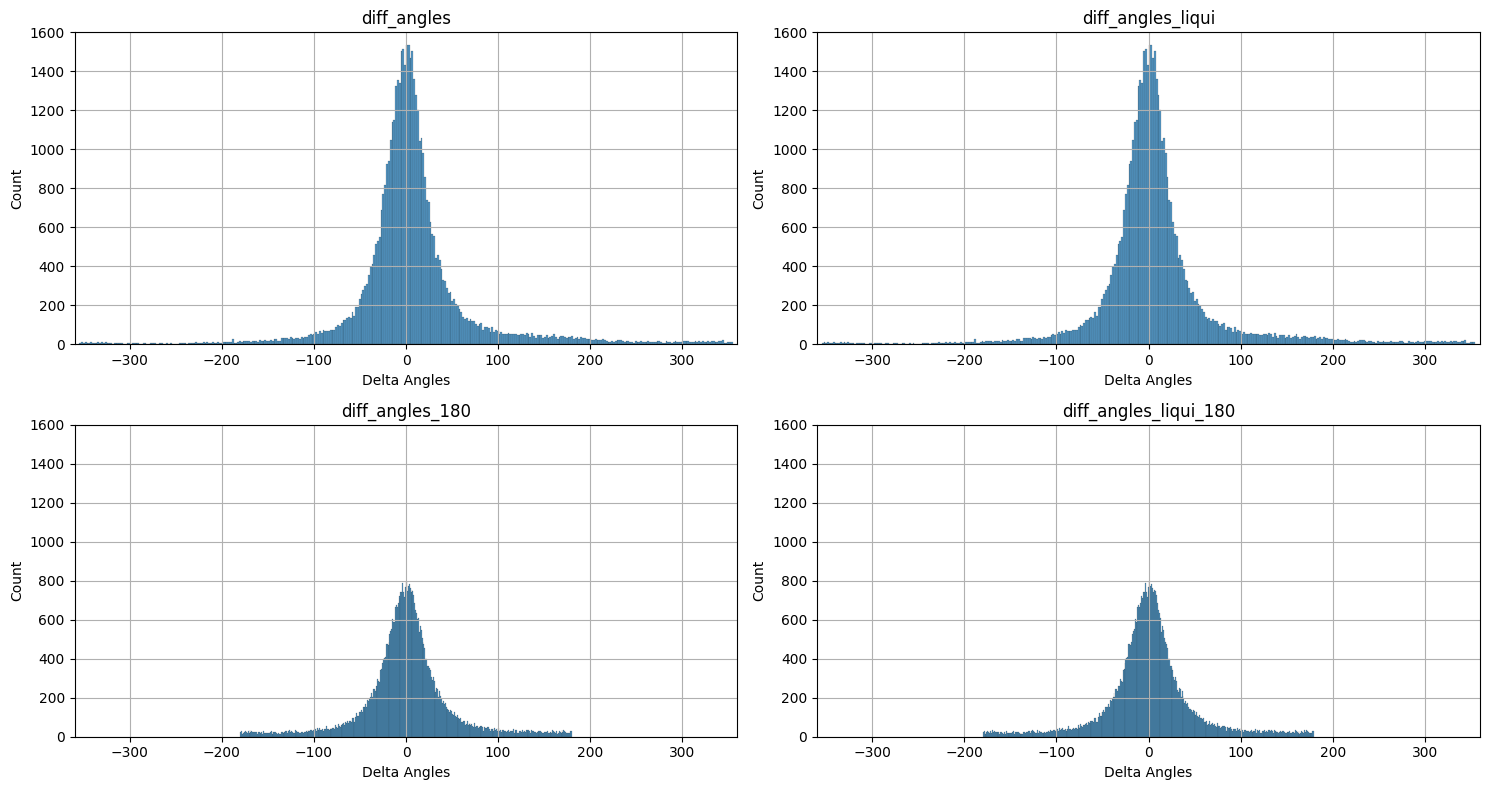

In [13]:
##histograms of estimate_angles and	estimate_angles_liqui
n_bins = 360
fig, ax = plt.subplots(2,2, figsize=(15,8))
sns.histplot(data=data_processed, x='diff_angles', bins=n_bins, ax=ax[0,0])
sns.histplot(data=data_processed, x='diff_angles_liqui', bins=n_bins, ax=ax[0,1])
sns.histplot(data=data_processed, x='diff_angles_180', bins=n_bins, ax=ax[1,0])
sns.histplot(data=data_processed, x='diff_angles_liqui_180', bins=n_bins, ax=ax[1,1])
ax[0,0].set_title("diff_angles")
ax[0,1].set_title("diff_angles_liqui")
ax[0,0].set_xlabel("Delta Angles")
ax[0,1].set_xlabel("Delta Angles")
ax[1,0].set_title("diff_angles_180")
ax[1,1].set_title("diff_angles_liqui_180")
ax[1,0].set_xlabel("Delta Angles")
ax[1,1].set_xlabel("Delta Angles")
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()
##limitting the x axes to -360 and 360 and the y axes to 0 and 1400
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlim(-360,360)
        ax[i,j].set_ylim(0,1600)

##tight layout
plt.tight_layout()
plt.show()

Again, apparently the angles are the same for both functions.

In [14]:
# print(data_processed.head())

### Columns added

- reaction_time_range: Discrete numbers for reaction time ranges.
- reaction_time_range_label: Label (in seconds) for the reaction time range.
- estimate_angles: Estimated angles using estimate_x and estimate_y. Using $angle = (arctan(frac{y}{x})\times\frac{180}{\pi}) \% 360$
- diff_angles: Difference between *motion_direction* and *estimate_angles* using 

#### Saving the data

In [15]:
##saving the new data
data_processed.to_csv("dataset\data_processed.csv")

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\corre\AppData\Local\Temp\ipykernel_16288\568595744.py:2: SyntaxWarning: invalid escape sequence '\d'
  data_processed.to_csv("dataset\data_processed.csv")


---

# Hypothesis 

1. Investigating the Influence of Prior Knowledge on the Learning Process —Regression

Predictive Value of Recent Trials:  examine how the performance accuracy of the last few trials forecasts the accuracy of subsequent trials (see the next plots).


2. Drivers of Learning Curve Modulation: whether changes in the learning curve within a block are primarily driven by task coherence or prior knowledge—Drift-Diffusion Model

    - Learning Across Prior Levels: Our findings indicate that subjects exhibit learning progress across different levels of prior knowledge.
    - Trial-to-Trial Dynamics: An in-depth analysis of trial-to-trial variations provides insights into the underlying mechanisms of learning.


### Difference between motion and estimated angles divided by prior_std

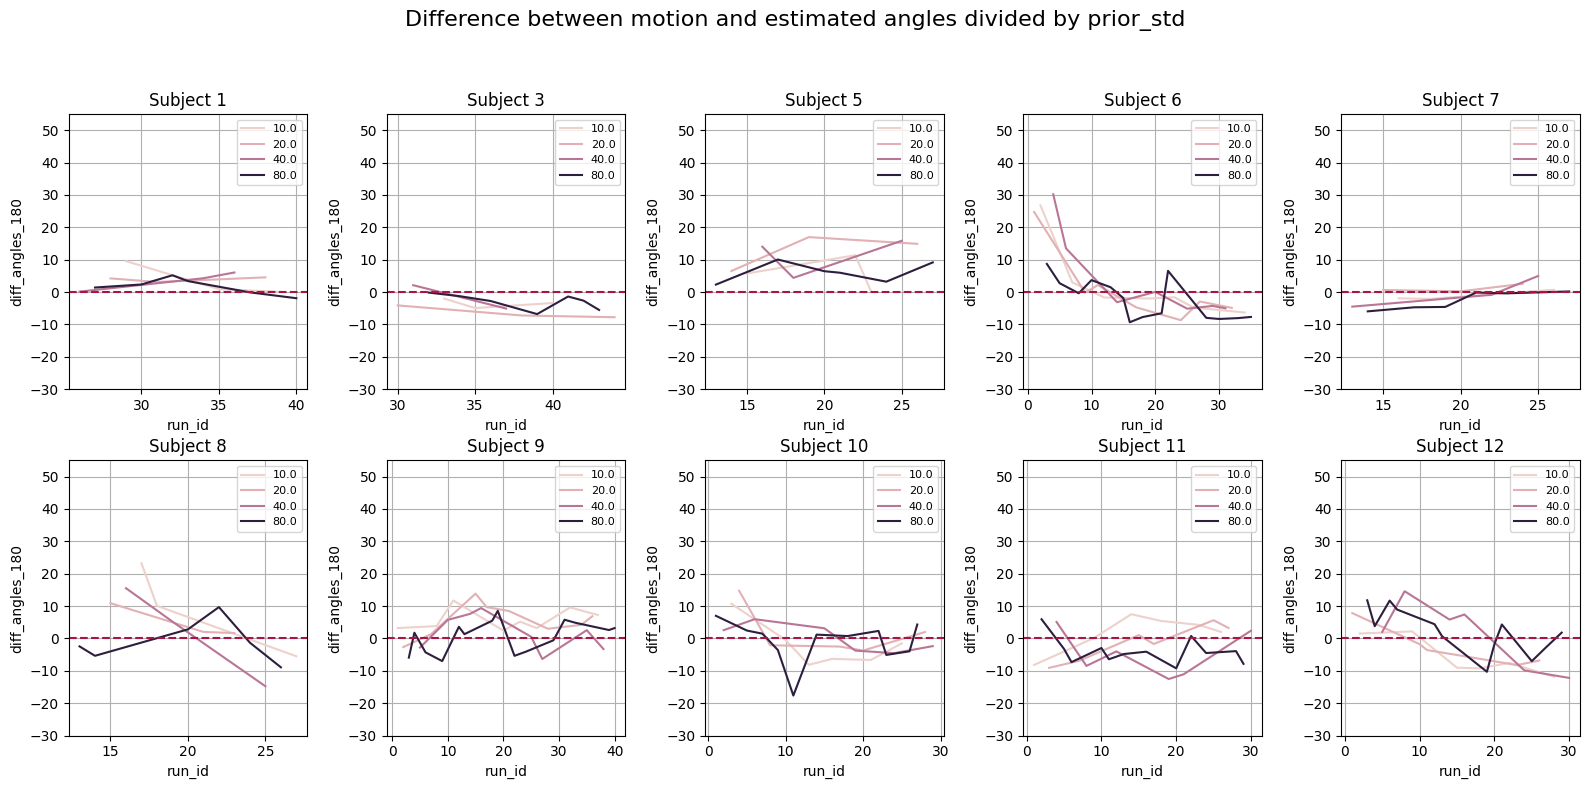

In [16]:
interest_cols = ["motion_direction","estimate_angles","diff_angles_180","prior_std"]
rows = 2
cols = 5
fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
subjects = data_processed["subject_id"].unique()
accum = 0
for i in range(rows):
    for j in range(cols):
        ##grouping the data by run_id for each subject
        temp_data = data_processed[data_processed["subject_id"] == subjects[accum]]
        grups = temp_data.groupby("run_id")[interest_cols].mean()
        sns.lineplot(grups, x = grups.index ,y="diff_angles_180", hue = "prior_std",ax=axs[i,j])
        axs[i,j].set_title(f"Subject {subjects[accum]}") 
        accum += 1
        ##adding a horizontal line at 0
        axs[i,j].axhline(0, color="#aa1445", linestyle="--")
        ##fontsize of legend in 8
        axs[i,j].legend(fontsize=8)
        ##limit the y-axis to -15 and 55
        axs[i,j].set_ylim(-30,55)
        ##grid on
        axs[i,j].grid()
plt.tight_layout()
##general title
plt.suptitle("Difference between motion and estimated angles divided by prior_std", fontsize=16)
##adding space between the subplots
plt.subplots_adjust(top=0.85)
plt.show()

#### 1. Plotting Temporal Learning Patterns:
- Sequential trials will be plotted to observe the learning curve over time.
- Analysis will focus on the first 10-20 trials in each block as a critical window for learning.

#### 2. Analysis of Prior Information:
- Trials will be split into segments (e.g., 0-10, 10-20, 20-30, ..., 90-100 trials).
- Differences in response angles will be compared between these segments and the last 10 or 20 trials.
- It is hypothesized that high standard deviation (STD) priors will require more trials to learn, shifting the learning curve to the right. Conversely, low STD priors will result in faster learning.

#### 3. Analysis of Sensory Coherence:
- Data will be reorganized by coherence levels.
- High coherence is expected to result in fast learning and high performance accuracy, with low differences in response angles.
- Low coherence is hypothesized to lead to slower learning, more mistakes, and potentially system crashes (inability to make a choice within 5 seconds, resulting in NaN).

In [17]:
##working on the 1. Plotting Temporal Learning Patterns:
#- Sequential trials will be plotted to observe the learning curve over time.
#- Analysis will focus on the first 10-20 trials in each block as a critical window for learning.

##grouping by subject_id, run_id and finally by trial_id, then getting the mean of the diff_angles
grups_mean = data_processed.groupby(["subject_id","run_id","trial_index","motion_coherence","prior_std"])[["diff_angles_liqui_180"]].mean().reset_index()
grups_mean.head()

,subject_id,run_id,trial_index,motion_coherence,prior_std,diff_angles_liqui_180
0,1,26,1,0.12,40,-4.796
1,1,26,2,0.12,40,19.285
2,1,26,3,0.12,40,35.710
3,1,26,4,0.06,40,37.530
4,1,26,5,0.06,40,-3.621


In [18]:
##number of subjects
n_subjects = data_processed["subject_id"].unique()
n_subjects #10 subjects

array([ 1,  3,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [19]:
data_processed.columns

Index(['trial_index', 'trial_time', 'response_arrow_start_angle',
       'motion_direction', 'motion_coherence', 'estimate_x', 'estimate_y',
       'reaction_time', 'raw_response_time', 'prior_std', 'prior_mean',
       'subject_id', 'experiment_name', 'experiment_id', 'session_id',
       'run_id', 'reaction_time_range', 'reaction_time_range_label',
       'estimate_angles', 'diff_angles', 'diff_angles_180',
       'estimate_angles_liqui', 'diff_angles_liqui', 'diff_angles_liqui_180'],
      dtype='object')

In [20]:
# ##line plot for the mean for each subject. The trial index should be on the x-axis
# nrows = 5
# ncols = 2
# acumm = 0
# fig, ax = plt.subplots(nrows,ncols, figsize=(18,10))
# for i in range(ncols):
#     for j in range(nrows):
#         temp_data = grups_mean[grups_mean["subject_id"] == n_subjects[acumm]]
#         sns.lineplot(data=temp_data, x="trial_index", y="diff_angles_liqui_180",  ax=ax[j,i])
#         ax[j,i].set_title(f"Subject {n_subjects[acumm]}")
#         ax[j,i].axhline(0, color="red", linestyle="--")
#         ##add a shadow to the plot between 0 and 20 in the trials axis
#         ax[j,i].axvspan(0, 20, color='#ffaa00', alpha=0.1)
#         ax[j,i].grid()
#         acumm += 1
# plt.tight_layout()
# ##add a general title
# plt.suptitle("Average Diff angles vs trial devided by $run_{id}$/block", fontsize=16)
# plt.subplots_adjust(top=0.91)
# plt.show()


Now, we'll divide the plots for each block/run_id.

In [21]:
# ##line plot for the mean for each subject divided by run_id. The trial index should be on the x-axis
# nrows = 5
# ncols = 2
# acumm = 0
# fig, ax = plt.subplots(nrows,ncols, figsize=(18,10))
# for i in range(ncols):
#     for j in range(nrows):
#         temp_data = grups_mean[grups_mean["subject_id"] == n_subjects[acumm]]
#         sns.lineplot(data=temp_data, x="trial_index", y="diff_angles_liqui_180", hue="run_id", ax=ax[j,i])
#         ##turn of the legend
#         # ax[j,i].legend().remove()
#         ax[j,i].set_title(f"Subject {n_subjects[acumm]}")
#         ax[j,i].axhline(0, color="red", linestyle="--")
#         ##add a shadow to the plot between 0 and 20 in the trials axis
#         ax[j,i].axvspan(0, 20, color='#ffaa00', alpha=0.1)
#         ax[j,i].grid()
#         acumm += 1
# plt.tight_layout()
# plt.suptitle("Diff angles vs trial devided by $run_{id}$/block", fontsize=16)
# plt.subplots_adjust(top=0.91)
# plt.show()

Now we will plot the first and the last blocks/run_id

In [22]:
##Now we will take the first and las run_id for each subject and plot the learning curve over time
grups_mean_pair = pd.DataFrame()
for i in n_subjects:
    temp_data = grups_mean[grups_mean["subject_id"] == i]
    runs_ids = temp_data["run_id"].unique()
    ##taking the first and last run_id
    first_run = temp_data[temp_data["run_id"] == runs_ids[0]]
    last_run = temp_data[temp_data["run_id"] == runs_ids[-1]]
    grups_mean_pair = pd.concat([grups_mean_pair, first_run, last_run])

Making the plots for the frist blocks.

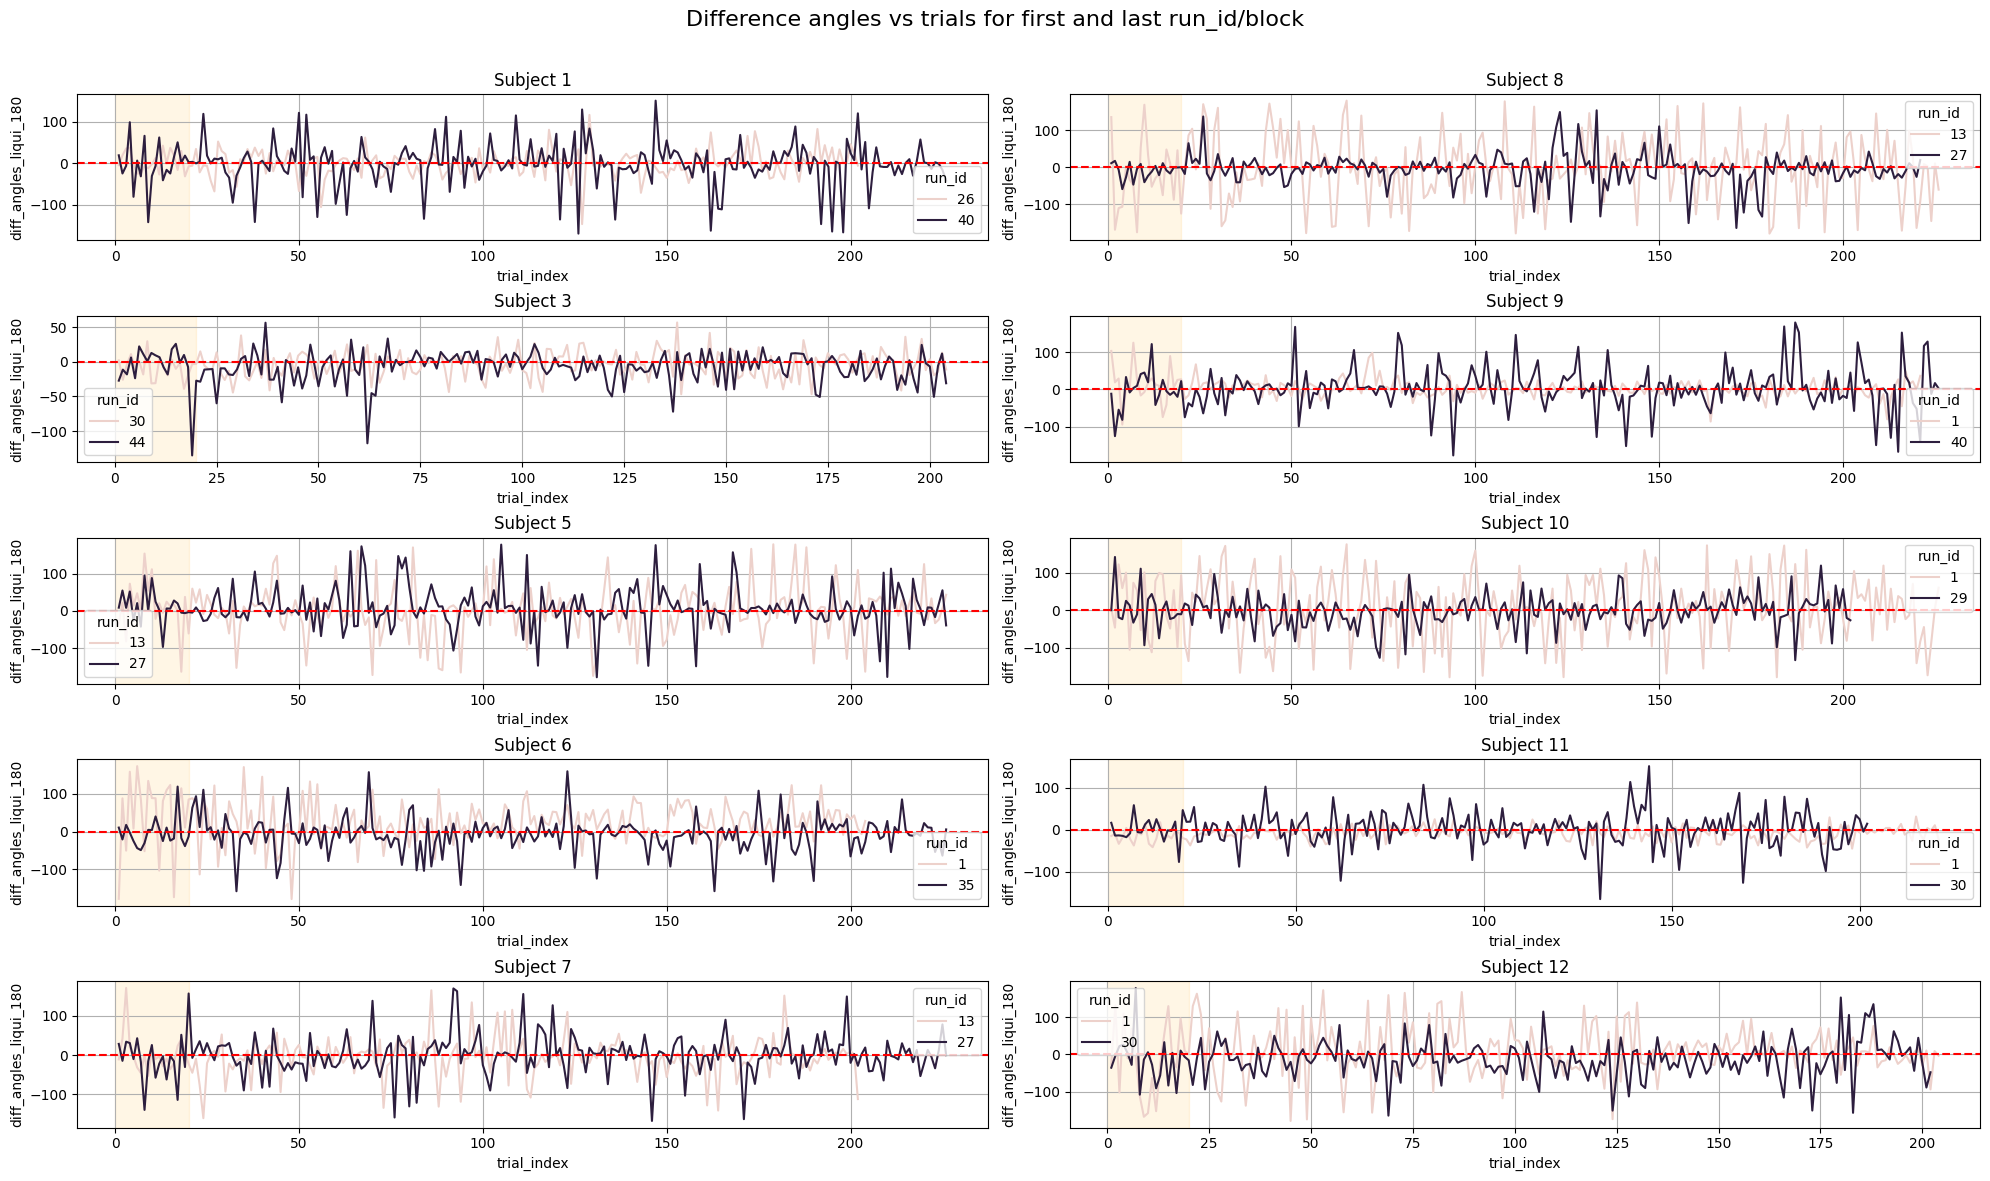

In [23]:
##line plot for the mean for each subject divided by run_id. The trial index should be on the x-axis
nrows = 5
ncols = 2
acumm = 0
fig, ax = plt.subplots(nrows,ncols, figsize=(20,12))
for i in range(ncols):
    for j in range(nrows):
        temp_data = grups_mean_pair[grups_mean_pair["subject_id"] == n_subjects[acumm]]
        sns.lineplot(data=temp_data, x="trial_index", y="diff_angles_liqui_180", hue="run_id", ax=ax[j,i])
        ##turn of the legend
        # ax[j,i].legend().remove()
        ax[j,i].set_title(f"Subject {n_subjects[acumm]}")
        ax[j,i].axhline(0, color="red", linestyle="--")
        ##add a shadow to the plot between 0 and 20 in the trials axis
        ax[j,i].axvspan(0, 20, color='#ffaa00', alpha=0.1)
        ax[j,i].grid()
        acumm += 1
plt.tight_layout()
plt.suptitle("Difference angles vs trials for first and last run_id/block", fontsize=16)
plt.subplots_adjust(top=0.91)
plt.show()

**DIVIDIR POR COHERENCIA!!!**